In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.io import savemat
from scipy import interpolate
import os, sys
import pickle
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/GM2022/data/esoh_R/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [ ]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 2.7,
        
   
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [ ]:
parameter_values.search("platin")

In [ ]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
#         "calculate discharge energy":"true"
    }
)

In [ ]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
    "Electrode width [m]":0.135,
    "Nominal cell capacity [A.h]":3.5,
    "Maximum concentration in negative electrode [mol.m-3]":27200,
    "Maximum concentration in positive electrode [mol.m-3]":33700,
    "Positive electrode thickness [m]":5.565e-05,
    "Negative electrode thickness [m]": 5.5605e-05,
    # "Electrode width [m]" : 0.11,      
    "Negative particle radius [m]":13.5e-06,
    "Positive particle radius [m]":2.1e-06,
    "Positive electrode diffusion coefficient [m2.s-1]":8e-15,    

        
    }
)
cell = 41

In [ ]:
K_SEI_list=[4.20e-16  , 4.35e-16 , 2.76e-16]
D_SEI_list=[6.66e-19  , 3.69e-19 , 1.75e-19]
k_pl_list=[4.54e-10   , 4.64e-10 , 5.48e-10]
k_diss_list=[0        , 6.24e-04 ,     0   ]
b_LAM_p_list=[10.06e-8, 7.65e-08 ,  3.43e-7]
b_LAM_n_list=[8.73e-8 , 8.76e-08 ,  1.47e-7]
Ea_SEI_list=[6026     , 5997.629 ,   0.    ]
# March17(no diss)    ,March23(dis), July8
list_num=1
Temp = 25
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": 0.76553,
        "Positive electrode active material volume fraction": 0.55692,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 0*b_LAM_p_list[list_num], #10.0638e-08, #8.3747149e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":0*b_LAM_n_list[list_num],#8.7257e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant proportional term 2 [s-1]": 0,
        "Negative electrode LAM constant proportional term 2 [s-1]": 0,
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]":K_SEI_list[list_num],# 4.1964e-16,# 4.17385539e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": D_SEI_list[list_num], #6.6582e-19, #1.79830186e-18, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]":Ea_SEI_list[list_num],#6.02602e+03, # 6.18700763e+03, #1.87422275e+04,1.58777981e+04,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]":  1.3e3, #30000.0,# 1.3e06,
        "Lithium plating kinetic rate constant [m.s-1]":k_pl_list[list_num],#4.543e-10, # 4.50936e-10
        
        
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density": k_diss_list[list_num],
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.0,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        
    },
    check_already_exists=False,
)

In [ ]:
experiment33 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.5 hours",  
         "Rest for 20 minutes", 
         # Home
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",  
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 2.1 hours",  
         "Rest for 20 minutes",     
        )

    ]*100,
    termination="70% capacity",
#     cccv_handling="ode",
)
pybamm.set_logging_level("WARNING")
all_sumvars_dict = cycle_adaptive_simulation_V2(spm, parameter_values, experiment33,1, save_at_cycles=1)
with open('accl_sim_hamid2.pickle', 'rb') as handle:
    all_sumvars_dict2 = pickle.load(handle)


In [19]:
def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"b")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r--")
        ax.set_title(split_long_string(name))
        if k ==2 :
            ax.set_ylim([3,4.5])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sravan"] + ["Hamid"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

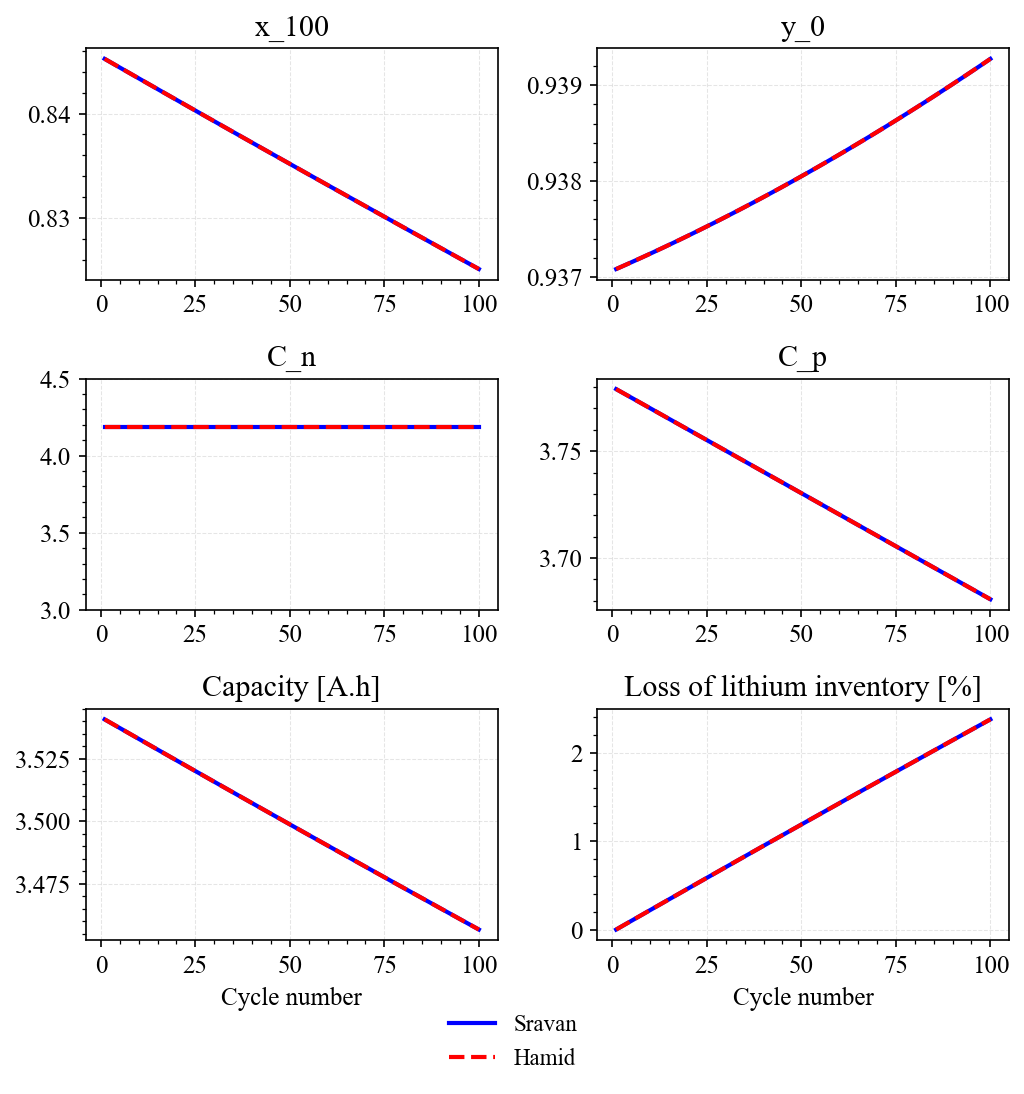

In [20]:
plotcomp(all_sumvars_dict,all_sumvars_dict2);

In [ ]:
sdfsdf

In [ ]:
#experimets
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# Half_Creeted_Drive = pd.read_csv("/Users/hamid/Drive Cycle/Half_hour_creeted_3p5Ah.csv", comment="#", header=None).to_numpy()

experiment33 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.5 hours",  
         "Rest for 20 minutes", 
         # Home
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",  
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 2.1 hours",  
         "Rest for 20 minutes",     
        )

    ]*1,
    termination="70% capacity",
#     cccv_handling="ode",
)





In [ ]:
pybamm.set_logging_level("NOTICE")

sim_long33 = pybamm.Simulation(spm, experiment=experiment33, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long33 = sim_long33.solve(initial_soc=1, save_at_cycles=1  )



# sim_long34 = pybamm.Simulation(spm, experiment=experiment34, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long34 = sim_long34.solve(initial_soc=1, save_at_cycles=1  )


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long33["Time [h]"].entries,sol_long33["Positive electrode SOC"].entries,"g")
# ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")

ax.set_title("Positive electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("y")
ax = axes.flat[1]
ax.plot(sol_long33["Time [h]"].entries,sol_long33["Negative electrode SOC"].entries,"g")
# ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")

ax.set_title("Negative electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("x")

In [ ]:
sim_long33.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
        "Positive particle surface concentration [mol.m-3]",
        "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Total lithium [mol]",
        "Total lithium in electrolyte [mol]",
        "Total lithium in negative electrode [mol]",
        "Total lithium in particles [mol]",
        "Total lithium in positive electrode [mol]",
        "Total lithium lost [mol]",
        "Total lithium lost from electrolyte [mol]",
        "Total lithium lost from particles [mol]",
        "Total lithium lost to side reactions [mol]",
        "Loss of lithium to lithium plating [mol]",
        "Loss of lithium to SEI [mol]",
        "X-averaged negative electrode lithium plating reaction overpotential [V]",

    ]
)

In [ ]:
with open('accl_sim_sravan.pickle', 'wb') as handle:
        pickle.dump(all_sumvars_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sol_long=sol_long33

x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]


LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
LLI_mol= sol_long.summary_variables["Total lithium lost [mol]"]
LLI_Side_mol= sol_long.summary_variables["Total lithium lost to side reactions [mol]"]
LLI_plating_mol= sol_long.summary_variables["Loss of lithium to lithium plating [mol]"]
LLI_SEI_mol= sol_long.summary_variables["Loss of lithium to SEI [mol]"]


cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

In [ ]:
LLI_plating_mol[-1]

In [ ]:
ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "LLI_mol":LLI_mol,
        "LLI_Side_mol":LLI_Side_mol
    
       }
savemat("GMJuly__experiment33_sravan.mat",mdic)